In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import math  
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,120,170,174,237,273,281,299,349,367,423
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,212,223,243,259,277,304,333,361,377,383
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,511,584,716,847,986,1171,1251,1320,1423,1468
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,334,370,376,390,428,439,466,501,525,545
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,7,7,8,8,8,10,14,16,17


In [3]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])


In [4]:
df.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,120,170,174,237,273,281,299,349,367,423
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,212,223,243,259,277,304,333,361,377,383
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,511,584,716,847,986,1171,1251,1320,1423,1468
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,334,370,376,390,428,439,466,501,525,545
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,7,7,7,8,8,8,10,14,16,17


In [5]:
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

In [6]:
df['Date'] =pd.to_datetime(df.Date)


In [7]:
df = df[df['Country/Region'] != 'China']
df_c = df
df.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [8]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()

In [9]:
df['Day num'] = np.arange(1, len(df)+1)
df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


In [10]:
pop = pd.read_csv('datasets\population_by_country_2020.csv')
pop.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [11]:
pop = pop[['Country (or dependency)', 'Population (2020)']].rename(columns = {'Country (or dependency)':'Country/Region',
                  'Population (2020)': 'Population'})

In [12]:
pop.head()

,Country/Region,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


# SIR model

In [13]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.6, 1/10

In [14]:
# The SIR model differential equations.
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [15]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
# ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma))
ret = odeint(SIR, y0, [i for i in range(1000)], args=(N, beta, gamma))

S, I, R = ret.T


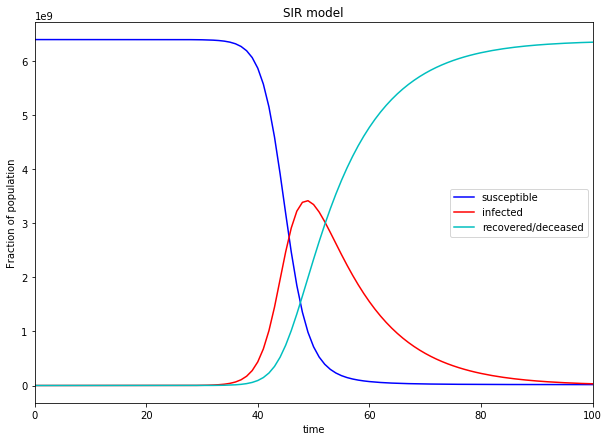

In [16]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()

In [17]:
train = 0.85
index = math.ceil(train * len(df['Confirmed'].values))
index

65

In [18]:
Y = df['Confirmed'].values
X = x = df['Day num'].values

In [19]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = 6.4 *(10**9)
I0, R0 = y[0], 0
S0 = N - I0 - R0

In [20]:
def opt_sir(x, beta, gamma):
    return odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))[:,1].clip(0)

def err_sir(params, x):
    beta, gamma = params
    ret = odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))
    S, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [21]:
popt, pcov = optimize.curve_fit(opt_sir, x, y, bounds = [0, np.inf])

result = optimize.minimize(err_sir, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.23292472291990196
 hess_inv: array([[1.32171211e-08, 1.93479659e-08],
       [1.93479659e-08, 2.88870605e-08]])
      jac: array([-0.0005536 ,  0.00087128])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 303
      nit: 10
     njev: 73
   status: 2
  success: False
        x: array([2.542821  , 2.37276481])


In [22]:
# pcov

In [23]:
# fitted = opt_ode(x, *popt)
fitted = opt_sir(x, *beta_hat)

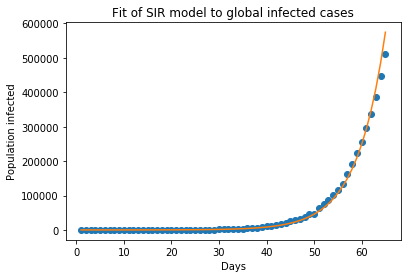

Optimal parameters: beta = 2.542820996977094  and gamma =  2.372764806921111


In [24]:
plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", beta_hat[0], " and gamma = ", beta_hat[1])

In [25]:
# beta, gamma = popt[0], popt[1]
beta, gamma = beta_hat[0], beta_hat[1]

In [26]:
y0 = S0, I0, R0
ret = odeint(SIR, y0, X, args=(N, beta, gamma))

S, I, R = ret.T


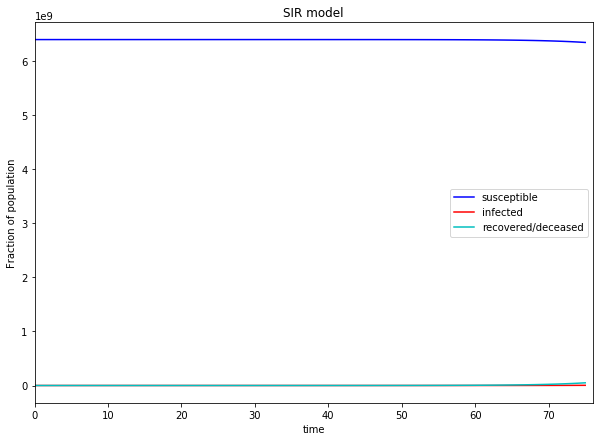

In [27]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,len(X))
plt.show()

In [28]:
y0 = S0, I0, R0
ret = odeint(SIR, y0, [i for i in range(100)], args=(N, beta, gamma))

S, I, R = ret.T

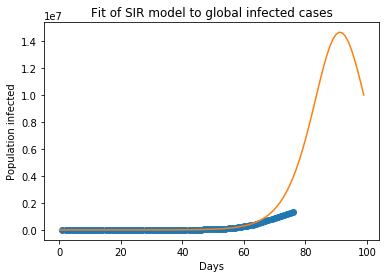

In [29]:
plt.plot(X, Y, 'o')
plt.plot([i for i in range(100)], I)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

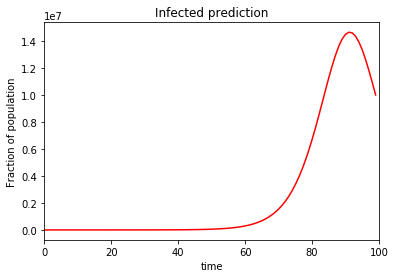

In [30]:
plt.plot(I, 'r', label='infected');
plt.title("Infected prediction")
plt.xlabel("time");
plt.ylabel("Fraction of population");
plt.xlim(0,100)
plt.show()

In [31]:
max(I)

14635197.305375388

In [32]:
max(df['Confirmed'].values)

1343378

In [33]:
lim = len(Y)
# mse = mean_squared_error(y, I[:lim])
rmsle = math.sqrt(mean_squared_log_error(Y[index:], I[index:lim]))
print(rmsle)

0.5659293728394666


# SEIR model

In [34]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, E0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - E0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma, sigma = 0.6, 1/10, 0.1

In [35]:
# The SEIR model differential equations.
def SEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [36]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SEIR, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


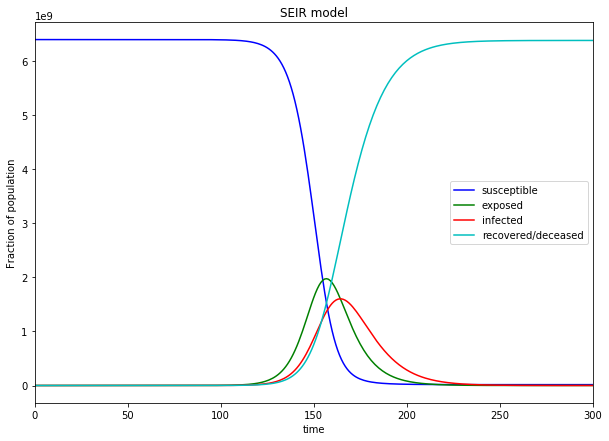

In [37]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(E, 'g', label='exposed');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

In [38]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

61

In [39]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [40]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [41]:
def opt_seir(x, beta, gamma, sigma):
    return odeint(SEIR, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))[:,1].clip(0)

def err_seir(params, x):
    beta, gamma, sigma = params
    ret = odeint(SEIR, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [42]:
# np.array(x)

In [43]:
popt, pcov = optimize.curve_fit(opt_seir, x, y, bounds = [0, np.inf])

result = optimize.minimize(err_seir, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.14707872676376893
 hess_inv: array([[3.91712056e-05, 2.86354190e-05, 4.07747377e-05],
       [2.86354190e-05, 3.48015366e-05, 5.57489353e-05],
       [4.07747377e-05, 5.57489353e-05, 9.12627118e-05]])
      jac: array([-0.00028967,  0.00096228, -0.00040648])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1520
      nit: 177
     njev: 302
   status: 2
  success: False
        x: array([-1.01129815, -1.09320767,  1.9109664 ])


In [44]:
# pcov

In [45]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(SEIR, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


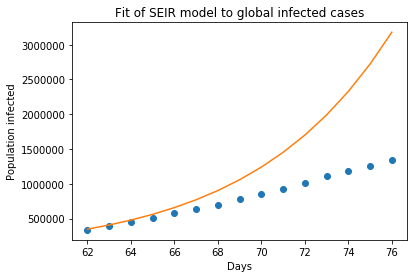

Optimal parameters: beta = -1.0112981497506746 , gamma =  -1.0932076689105175 , sigma =  1.9109663956205403


In [46]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", beta_hat[0], ", gamma = ", beta_hat[1],", sigma = ", beta_hat[2] )

In [47]:
# beta, gamma, sigma = popt[0], popt[1], popt[2]
beta, gamma, sigma = beta_hat[0], beta_hat[1], beta_hat[2]

In [48]:
y0 = S0, E0, I0, R0
ret = odeint(SEIR, y0, [i for i in range(200)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


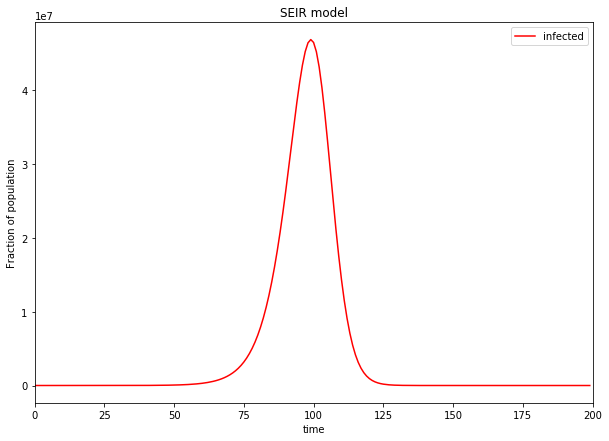

In [49]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b.', label='susceptible');
# plt.plot(E, 'g.', label='Exposed');
plt.plot(I, 'r', label='infected');
# plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,200)
plt.show()

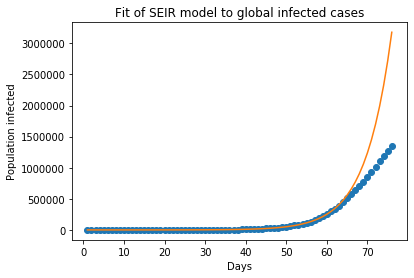

In [50]:
plt.plot(X, Y, 'o')
plt.plot(X, I[:len(Y)])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [51]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I[:len(Y)]))
print(rmsle)

0.08938257470061721


In [52]:
# [1/i for i in x][::-1]

In [53]:
max(I)

46864952.4378372

# SIQR model

In [54]:
# Total population, N without china
N = 6.4 *(10**9)
I0, R0, Q0 = 10, 0, 0
S0 = N - I0 - R0 - Q0
beta, gamma, alpha, theta = 2.0, 1/10, 1.0, 0.3

In [55]:
# The SIQR model differential equations.

def SIQR(y, t, N, alpha, beta, gamma, theta):
    S, I, Q, R = y
    dSdt = (-beta * S * I) / N
    dIdt = ((beta * S * I) / N) - ((theta + alpha) * I)
    dQdt = (theta * I) - (gamma * Q) 
    dRdt = (alpha * I) + (gamma * Q)
    return dSdt, dIdt, dQdt, dRdt


In [56]:
# Initial conditions vector
y0 = S0, I0, Q0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SIQR, y0, [i for i in range(100)], args=(N, alpha, beta, gamma, theta))

S, I, Q, R = ret.T


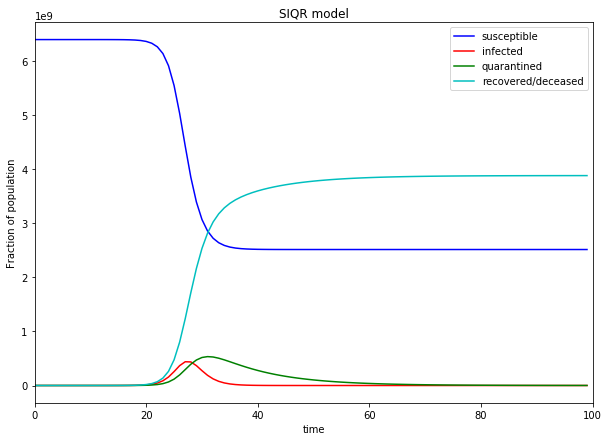

In [57]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(Q, 'g', label='quarantined');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIQR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()

In [58]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

61

In [59]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [60]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, Q0 = y[0], 0, 0
S0 = N - I0 - R0 - Q0

In [61]:
# S0

In [62]:
def opt_siqr(x, alpha, beta, gamma, theta):
    return odeint(SIQR, (S0, I0, Q0, R0), x, args=(N, alpha, beta, gamma, theta))[:,1].clip(0)

def err_siqr(params, x):
    alpha, beta, gamma, theta = params
    ret = odeint(SIQR, (S0, I0, Q0, R0), x, args=(N, alpha, beta, gamma, theta))
    S, I, Q, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [63]:
# np.array(x)

In [64]:
popt, pcov = optimize.curve_fit(opt_siqr, x, y, bounds = [0, np.inf])

result = optimize.minimize(err_siqr, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(beta_hat)


[-1.79412898 11.74460176 -3.36359343 13.36463007]


In [65]:
# pcov

In [66]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, I0, Q0, R0
ret = odeint(SIQR, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, I, Q, R = ret.T


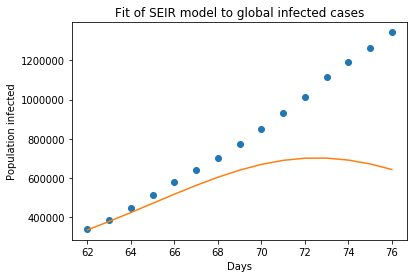

Optimal parameters: beta = -1.7941289826091216 , gamma =  11.744601759193738 , sigma =  -3.3635934260070592


In [67]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", beta_hat[0], ", gamma = ", beta_hat[1],", sigma = ", beta_hat[2] )

In [68]:
# beta, gamma, sigma, theta = popt[0], popt[1], popt[2], popt[3]
alpha, beta, gamma, theta = beta_hat[0], beta_hat[1], beta_hat[2], beta_hat[3]

In [69]:
y0 = S0, I0, Q0, R0
ret = odeint(SIQR, y0, [i for i in range(300)], args=(N, alpha, beta, gamma, theta))

S, I, Q, R = ret.T


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


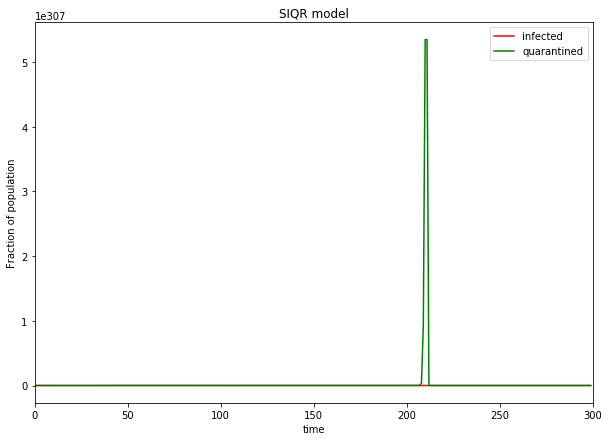

In [70]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(Q, 'g', label='quarantined');
# plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIQR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

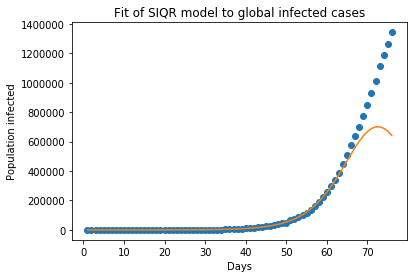

In [71]:
plt.plot(X, Y, 'o')
plt.plot(X, I[:len(Y)])
plt.title("Fit of SIQR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [72]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I[:len(Y)]))
print(rmsle)

0.1665998452824396


# SEIR with social distancing

In [73]:
# Total population, N without china
N = 6.4 *(10**9)
I0, R0, E0 = 1, 0, 0
S0 = N - I0 - R0 - E0
beta, gamma, sigma, alpha = 1.75, 0.5, 0.2, 0.5

In [74]:
# The SIR model differential equations.
def SEIRsd(y, t, N, beta, gamma, sigma, alpha):
    S, E, I, R = y
    dSdt = (-alpha * beta * S * I) / N
    dEdt = ((alpha * beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [75]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SEIRsd, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma, alpha))

S, E, I, R = ret.T


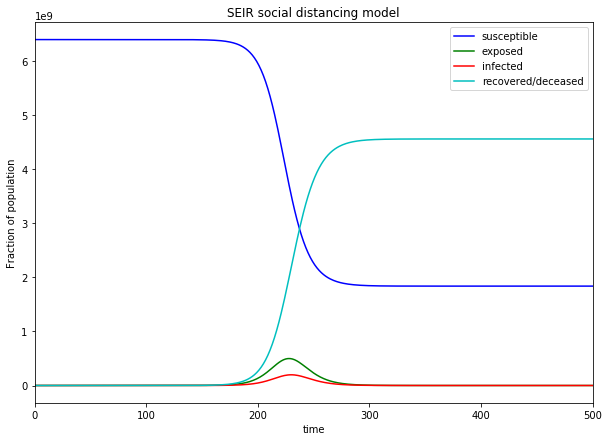

In [76]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(E, 'g', label='exposed');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SEIR social distancing model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,500)
plt.show()

## Comparison with and without social distancing

In [77]:
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret1 = odeint(SEIR, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma))

S1, E1, I1, R1 = ret1.T

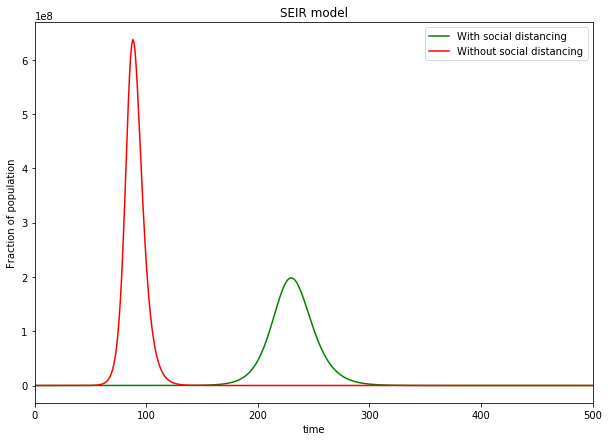

In [78]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'g', label='With social distancing');
plt.plot(I1, 'r', label='Without social distancing');
# plt.plot(R, 'c', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,500)
plt.show()

In [79]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

61

In [80]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [81]:
y = df['Confirmed'].values
x = df['Day num'].values

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [82]:
def opt_seirsd(x, beta, gamma, sigma, alpha):
#     if alpha > 1:
#         alpha = 1
#     elif alpha < 0:
#         alpha = 0
    return odeint(SEIRsd, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma, alpha))[:,1].clip(0)

def err_seirsd(params, x):
    beta, gamma, sigma, alpha = params
#     if alpha > 1:
#         alpha = 1
#     elif alpha < 0:
#         alpha = 0
    ret = odeint(SEIRsd, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma, alpha))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [83]:
# np.array(x)

In [84]:
popt, pcov = optimize.curve_fit(opt_seirsd, x, y, bounds = [0, np.inf])

result = optimize.minimize(err_seirsd, popt, args=(x), method='BFGS', options={'maxiter': 1000})

beta_hat = result.x
print(result)


      fun: 0.22545981434565437
 hess_inv: array([[ 5.00000543e-01, -7.04856918e-05, -1.04007495e-06,
        -4.99999457e-01],
       [-7.04856918e-05,  9.18540934e-03,  1.35538871e-04,
        -7.04856918e-05],
       [-1.04007495e-06,  1.35538871e-04,  2.00070980e-06,
        -1.04007495e-06],
       [-4.99999457e-01, -7.04856918e-05, -1.04007495e-06,
         5.00000543e-01]])
      jac: array([-0.22553078, -0.35682102, 30.90648222, -0.22553078])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 729
      nit: 21
     njev: 120
   status: 2
  success: False
        x: array([ 3.30367991e+00, -2.77576252e-01, -1.81283214e-03,  3.30367991e+00])


In [85]:
# pcov

In [86]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(SEIRsd, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


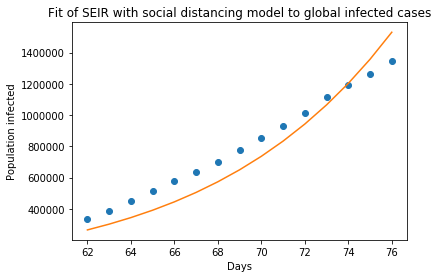

Optimal parameters: beta = 3.5384503249441464 , gamma =  0.020508404385432614 , sigma =  0.0010454374697839587


In [87]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR with social distancing model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], ", gamma = ", popt[1],", sigma = ", popt[2] )

In [88]:
# beta, gamma, sigma = popt[0], popt[1], popt[2]
beta, gamma, sigma, alpha = beta_hat[0], beta_hat[1], beta_hat[2], beta_hat[3]

In [89]:
y0 = S0, E0, I0, R0
ret = odeint(SEIRsd, y0, [i for i in range(500)], args=(N, beta, gamma, sigma, alpha))

S, E, I, R = ret.T


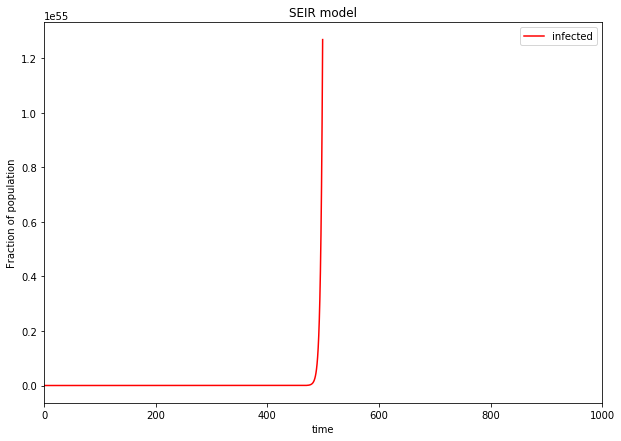

In [90]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b.', label='susceptible');
# plt.plot(E, 'g.', label='Exposed');
plt.plot(I, 'r', label='infected');
# plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.show()

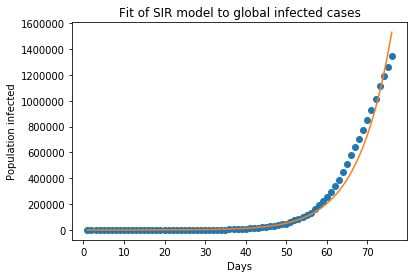

In [91]:
plt.plot(X, Y, 'o')
plt.plot(X, I[:len(Y)])
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [92]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I[:len(Y)]))
print(rmsle)

0.12591799334041012


# Analysing each country individualy

In [93]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [94]:
df_c = df_c.replace('US', 'United States').replace('Korea, South', 'South Korea')

In [95]:
countries = list(set(df_c['Country/Region'].values).intersection(set(pop['Country/Region'].values)))
# len(countries)

In [96]:
country = 'Kenya'

In [97]:
temp = df_c[df_c['Country/Region'] == country].reset_index()
temp = temp[temp['Confirmed'] > 0].fillna(0)
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,index,Country/Region,Lat,Long,Date,Confirmed
50,9289,Kenya,-0.0236,37.9062,2020-03-13,1
51,9473,Kenya,-0.0236,37.9062,2020-03-14,1
52,9657,Kenya,-0.0236,37.9062,2020-03-15,3
53,9841,Kenya,-0.0236,37.9062,2020-03-16,3
54,10025,Kenya,-0.0236,37.9062,2020-03-17,3


In [98]:
N = int(pop[pop['Country/Region'] == country]['Population'])
N

53771296

In [99]:
temp['Day num'] = np.arange(1, len(temp)+1)
temp.tail()

,index,Country/Region,Lat,Long,Date,Confirmed,Day num
71,13153,Kenya,-0.0236,37.9062,2020-04-03,122,22
72,13337,Kenya,-0.0236,37.9062,2020-04-04,126,23
73,13521,Kenya,-0.0236,37.9062,2020-04-05,142,24
74,13705,Kenya,-0.0236,37.9062,2020-04-06,158,25
75,13889,Kenya,-0.0236,37.9062,2020-04-07,172,26


In [100]:
y = temp['Confirmed'].values[:index]
x = temp['Day num'].values[:index]

I0, R0 = y[0], 0
S0 = N - I0 - R0

In [101]:
def opt_ode(x, beta, gamma):
    return odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))[:,1].clip(0)

def err(params, x):
    beta, gamma = params
    ret = odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))
    S, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [102]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(popt)
print(result)


[10.86038809 10.64632776]
      fun: 0.30251958959908665
 hess_inv: array([[0.08369357, 0.08322172],
       [0.08322172, 0.08300588]])
      jac: array([ 0.0004156 , -0.00036942])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 206
      nit: 5
     njev: 49
   status: 2
  success: False
        x: array([10.8619684, 10.6452107])


In [103]:
# pcov

In [104]:
# fitted = opt_ode(x, *popt)
fitted = opt_ode(x, *beta_hat)

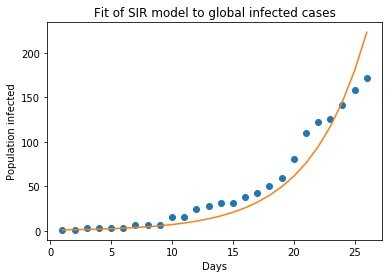

Optimal parameters: beta = 10.860388093067899  and gamma =  10.646327764163589


In [105]:
plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [106]:
lim = len(y)
# mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(y, fitted))
print(rmsle)

0.14767075585750783
